In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 




import json



In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.roberta_conf
encoding_type = 'absolute'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_roberta_about_abs'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.5102040816326531
MALE 0.0
FEMALE 1.0 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.4810606060606061
MALE 0.0
FEMALE 1.0 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.48370273794002605
MALE 0.0
FEMALE 1.0 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6839543406556292 	 Validation loss: 0.684440809791371 	 
  1%|          | 574/57400 [01:19<1:59:21,  7.93it/s]
Epoch 2 	 Training loss: 0.6818197676944401 	 Validation loss: 0.6841403912689726 	 
  2%|▏         | 1148/57400 [02:39<1:58:57,  7.88it/s]
Epoch 3 	 Training loss: 0.6813072034706222 	 Validation loss: 0.6839960672087588 	 
  3%|▎         | 1722/57400 [03:59<1:56:50,  7.94it/s]
Epoch 4 	 Training loss: 0.6807299190905036 	 Validation loss: 0.683020881677078 	 
  4%|▍         | 2296/57400 [05:19<2:02:23,  7.50it/s]
Epoch 5 	 Training loss: 0.6793864320587198 	 Validation loss: 0.6818731255450491 	 
  5%|▌         | 2870/57400 [06:39<1:57:47,  7.72it/s]
Epoch 6 	 Training loss: 0.6765173624824564 	 Validation loss: 0.6764198834613219 	 
  6%|▌         | 3444/57400 [08:00<2:00:32,  7.46it/s]
Epoch 7 	 Training loss: 0.6322146662436295 	 Validation loss: 0.5155422773401616 	 
  7%|▋         | 4018/57400 [09:20<2:05:13,  7.10it/s]
Epoch 8 	 Training loss

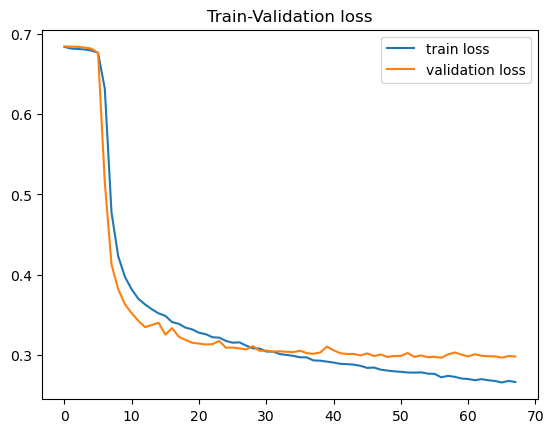

In [17]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8622448979591837
MALE 0.8723958333333334
FEMALE 0.8525 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6944444444444444
MALE 0.7104622871046229
FEMALE 0.6771653543307087 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6897001303780965
MALE 0.702020202020202
FEMALE 0.6765498652291105 



# TO

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_roberta_to_abs'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.69420454487568 	 Validation loss: 0.6933020615981798 	 
  1%|          | 574/57400 [01:18<1:56:28,  8.13it/s]
Epoch 2 	 Training loss: 0.6937642446378383 	 Validation loss: 0.6930530111668474 	 
  2%|▏         | 1148/57400 [02:37<2:11:54,  7.11it/s]
Epoch 3 	 Training loss: 0.6933746159284372 	 Validation loss: 0.6941941239066043 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [03:55<1:54:44,  8.09it/s]
Epoch 4 	 Training loss: 0.6933563644462346 	 Validation loss: 0.6926278249692108 	 
  4%|▍         | 2296/57400 [05:14<1:45:55,  8.67it/s]
Epoch 5 	 Training loss: 0.693439159762984 	 Validation loss: 0.6933466337494931 	 
  5%|▌         | 2870/57400 [06:32<1:46:04,  8.57it/s]
Epoch 6 	 Training loss: 0.6934038987350796 	 Validation loss: 0.6931824320453709 	 
  6%|▌         | 3444/57400 [07:51<2:00:29,  7.46it/s]
Epoch 7 	 Training loss: 0.6931851719106946 	 Validation loss: 0.6933757804207883 	 
  7%|▋         | 4018/57400 [09:09<1:48:25,  8.21i

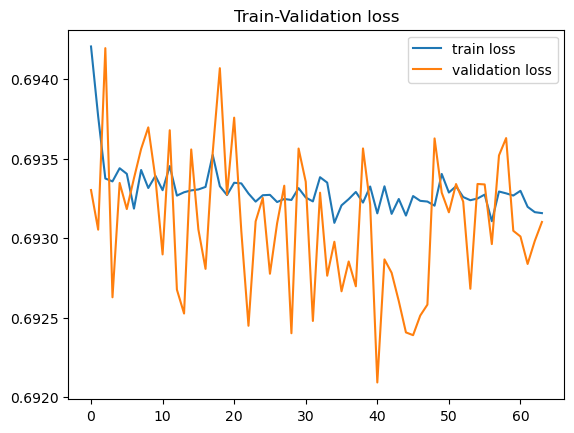

In [20]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.5408163265306123
MALE 0.1015625
FEMALE 0.9625 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.4936868686868687
MALE 0.06326034063260341
FEMALE 0.958005249343832 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.4941329856584094
MALE 0.05808080808080808
FEMALE 0.9595687331536388 



# AS

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_roberta_as_abs'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6944895102171947 	 Validation loss: 0.6923839055885703 	 
  1%|          | 574/57400 [01:18<1:56:43,  8.11it/s]
Epoch 2 	 Training loss: 0.6935051780336825 	 Validation loss: 0.6931466621867681 	 
  2%|▏         | 1148/57400 [02:36<2:01:19,  7.73it/s]
Epoch 3 	 Training loss: 0.6933413263189668 	 Validation loss: 0.6930576966980756 	 
  3%|▎         | 1722/57400 [03:54<1:55:33,  8.03it/s]
Epoch 4 	 Training loss: 0.6934356739296731 	 Validation loss: 0.6928052164740481 	 
  4%|▍         | 2296/57400 [05:12<1:53:18,  8.11it/s]
Epoch 5 	 Training loss: 0.6934532788987774 	 Validation loss: 0.6933055358417963 	 
  5%|▌         | 2870/57400 [06:31<1:57:21,  7.74it/s]
Epoch 6 	 Training loss: 0.6933982460548653 	 Validation loss: 0.6926859132314133 	 
  6%|▌         | 3444/57400 [07:49<2:01:35,  7.40it/s]
Epoch 7 	 Training loss: 0.6933973912370329 	 Validation loss: 0.6928997464099172 	 
  7%|▋         | 4018/57400 [09:07<1:50:53,  8.02it/s]
Epoch 8 	 Training lo

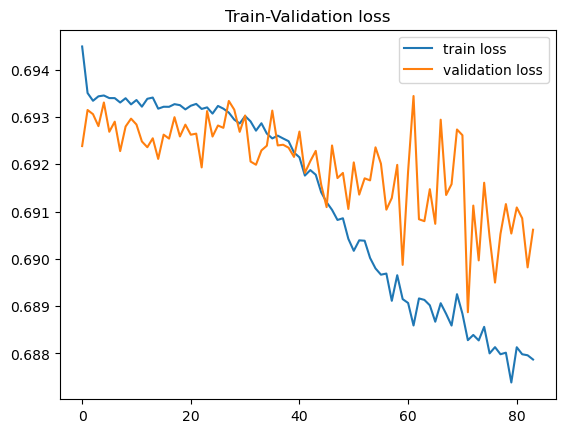

In [23]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [24]:

model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.6721938775510204
MALE 0.6640625
FEMALE 0.68 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.7133838383838383
MALE 0.7274939172749392
FEMALE 0.6981627296587927 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.7249022164276402
MALE 0.6565656565656566
FEMALE 0.7978436657681941 

